In [2]:
import dolfinx
print(dolfinx.__version__)

0.10.0


In [3]:
from mpi4py import MPI

import gmsh
import numpy as np

import dolfinx.fem.petsc
import ufl

gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
c_y = 1
R = 0.5
potential_contact_marker = 2
displacement_marker = 1
res = 0.2
order = 2
refinement_level = 2

# Initialize gmsh
gmsh.initialize()
if MPI.COMM_WORLD.rank == 0:
    # Create disk and subtract top part
    membrane = gmsh.model.occ.addDisk(0, c_y, 0, R, R)
    square = gmsh.model.occ.addRectangle(-R, c_y, 0, 2 * R, 1.1 * R)
    gmsh.model.occ.synchronize()
    new_tags, _ = gmsh.model.occ.cut([(2, membrane)], [(2, square)])
    gmsh.model.occ.synchronize()

    # Split boundary into two components
    boundary = gmsh.model.getBoundary(new_tags, oriented=False)
    contact_boundary = []
    dirichlet_boundary = []
    for bnd in boundary:
        mass = gmsh.model.occ.getMass(bnd[0], bnd[1])
        if np.isclose(mass, np.pi * R):
            contact_boundary.append(bnd[1])
        elif np.isclose(mass, 2 * R):
            dirichlet_boundary.append(bnd[1])
        else:
            raise RuntimeError("Unknown boundary")

    # Tag physical groups for the surface
    for i, tags in enumerate(new_tags):
        gmsh.model.addPhysicalGroup(tags[0], [tags[1]], i + 1)

    # Tag physical groups for the boundary
    gmsh.model.add_physical_group(1, contact_boundary, potential_contact_marker)
    gmsh.model.add_physical_group(1, dirichlet_boundary, displacement_marker)

    # Create higher resolution mesh at the contact boundary
    distance_field = gmsh.model.mesh.field.add("Distance")
    gmsh.model.mesh.field.setNumbers(distance_field, "EdgesList", contact_boundary)
    threshold = gmsh.model.mesh.field.add("Threshold")
    gmsh.model.mesh.field.setNumber(threshold, "IField", distance_field)
    gmsh.model.mesh.field.setNumber(threshold, "LcMin", res)
    gmsh.model.mesh.field.setNumber(threshold, "LcMax", 20 * res)
    gmsh.model.mesh.field.setNumber(threshold, "DistMin", 0.075 * R)
    gmsh.model.mesh.field.setNumber(threshold, "DistMax", 0.5 * R)
    gmsh.model.mesh.field.setAsBackgroundMesh(threshold)

    # Generate mesh, make second order and refine
    gmsh.model.mesh.generate(2)
    gmsh.model.mesh.setOrder(order)
    for _ in range(refinement_level):
        gmsh.model.mesh.refine()
        gmsh.model.mesh.setOrder(order)
    gmsh.write("example.msh")
gmsh.finalize()

Info    : Meshing 1D...                                                                                                                          
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 60%] Meshing curve 2 (Line)
Info    : Done meshing 1D (Wall 0.00101474s, CPU 0.000373s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00403588s, CPU 0.00135s)
Info    : 57 nodes 114 elements
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 40%] Meshing curve 2 order 2
Info    : [ 70%] Meshing surface 1 order 2
Info    : Surface mesh: worst distortion = 1 (0 elements in ]0, 0.2]); worst gamma = 0.839697
Info    : Done meshing order 2 (Wall 0.000427808s, CPU 0.000541s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 40%] Meshing curve 2 order 2
Info    : [ 70%] Meshing surface 1 order 2
Info    : Sur

Info    : Reading 'example.msh'...
Info    : 5 entities
Info    : 2913 nodes
Info    : 1504 elements
Info    : Done reading 'example.msh'


/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


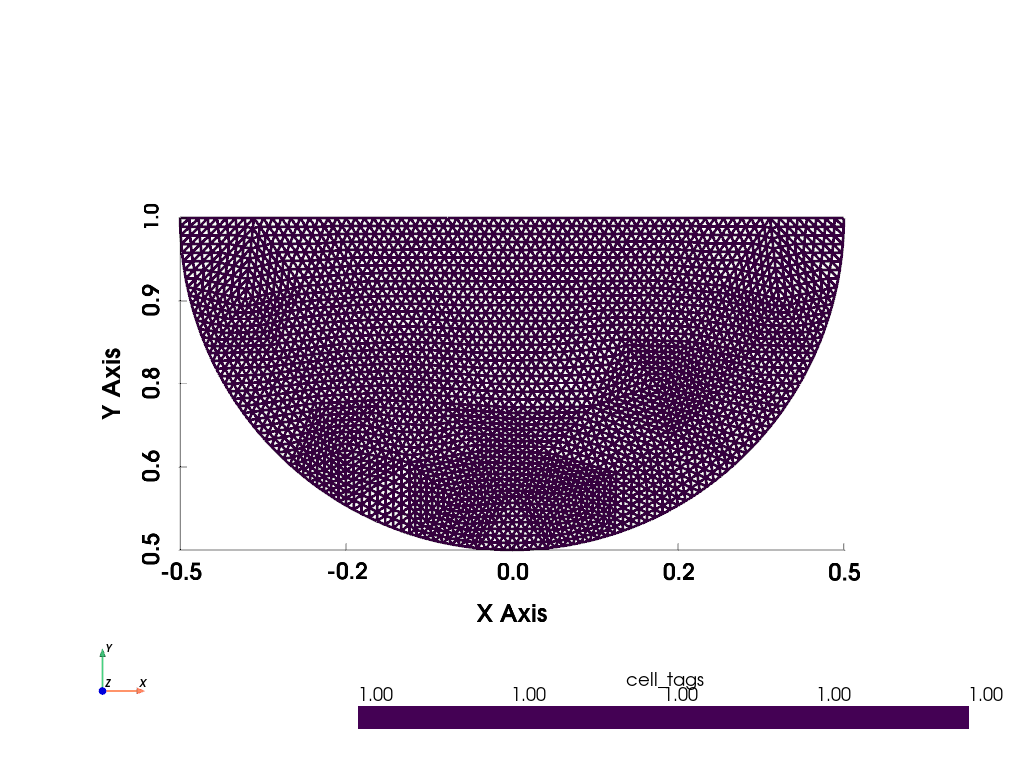

/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


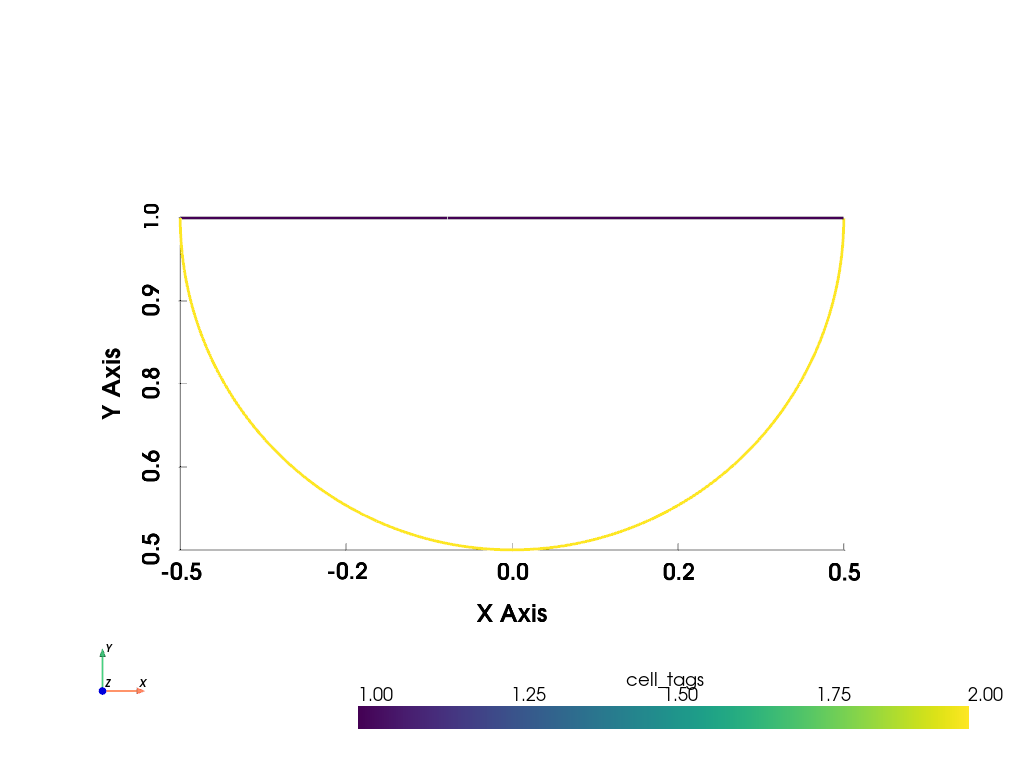

In [4]:
# We inspect the generated mesh and markers
from dolfinx.io import gmsh as gmshio
# mesh_data = dolfinx.io.gmsh.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=2)
omega, ct, ft = gmshio.read_from_msh("example.msh", MPI.COMM_WORLD, 0, gdim=2)[0:3]
# omega = mesh_data.mesh
# ct = mesh_data.cell_tags
# ft = mesh_data.facet_tags
# gmsh.finalize()

import pyvista


def plot_mesh(mesh: dolfinx.mesh.Mesh, tags: dolfinx.mesh.MeshTags = None, style: str = "surface"):
    plotter = pyvista.Plotter()
    tdim = mesh.topology.dim
    mesh.topology.create_connectivity(tdim - 1, tdim)
    if tags is None:
        ugrid = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(mesh))
    else:
        # Exclude indices marked zero
        exclude_entities = tags.find(0)
        marker = np.full_like(tags.values, True, dtype=np.bool_)
        marker[exclude_entities] = False
        ugrid = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(mesh, tags.dim, tags.indices[marker]))
        ugrid.cell_data[ct.name] = tags.values[marker]

    plotter.add_mesh(ugrid, show_edges=True, line_width=3, style=style)
    plotter.show_axes()
    plotter.view_xy()
    plotter.show_bounds()
    plotter.show()


plot_mesh(omega, ct, style="wireframe")
plot_mesh(omega, ft)

In [5]:
tdim = omega.topology.dim
fdim = tdim - 1
gdim = omega.geometry.dim
gamma, gamma_to_omega = dolfinx.mesh.create_submesh(omega, fdim, ft.find(potential_contact_marker))[0:2]

In [6]:
V = dolfinx.fem.functionspace(omega, ("Lagrange", 1, (omega.geometry.dim,)))
Q = dolfinx.fem.functionspace(gamma, ("Lagrange", 1))
W = ufl.MixedFunctionSpace(V, Q)

In [7]:
dx = ufl.Measure("dx", domain=omega)
ds = ufl.Measure("ds", domain=omega, subdomain_data=ft, subdomain_id=potential_contact_marker)

In [8]:
E = dolfinx.fem.Constant(omega, dolfinx.default_scalar_type(2e4))
nu = dolfinx.fem.Constant(omega, 0.4)
alpha = dolfinx.fem.Constant(omega, dolfinx.default_scalar_type(0.1))

In [9]:
h = 0.13
x, y = ufl.SpatialCoordinate(omega)
g = y + dolfinx.fem.Constant(omega, dolfinx.default_scalar_type(h))
uD = 0.72

In [10]:
n = ufl.FacetNormal(omega)
n_g = dolfinx.fem.Constant(omega, np.zeros(gdim, dtype=dolfinx.default_scalar_type))
n_g.value[-1] = -1
f = dolfinx.fem.Constant(omega, np.zeros(gdim, dtype=dolfinx.default_scalar_type))

In [11]:
v, w = ufl.TestFunctions(W)
u = dolfinx.fem.Function(V, name="Displacement")
psi = dolfinx.fem.Function(Q, name="Latent_variable")
psi_k = dolfinx.fem.Function(Q, name="Previous_Latent_variable")

mu = E / (2.0 * (1.0 + nu))
lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))


def epsilon(w):
    return ufl.sym(ufl.grad(w))


def sigma(w, mu, lmbda):
    ew = epsilon(w)
    gdim = ew.ufl_shape[0]
    return 2.0 * mu * epsilon(w) + lmbda * ufl.tr(ufl.grad(w)) * ufl.Identity(gdim)


F = alpha * ufl.inner(sigma(u, mu, lmbda), epsilon(v)) * dx
F -= alpha * ufl.inner(f, v) * dx
F += -ufl.inner(psi - psi_k, ufl.dot(v, n)) * ds
F += ufl.inner(ufl.dot(u, n_g), w) * ds
F += ufl.inner(ufl.exp(psi), w) * ds - ufl.inner(g, w) * ds
residual = ufl.extract_blocks(F)

In [12]:
du, dpsi = ufl.TrialFunctions(W)
jac = ufl.derivative(F, u, du) + ufl.derivative(F, psi, dpsi)
J = ufl.extract_blocks(jac)

In [13]:
def disp_func(x):
    values = np.zeros((gdim, x.shape[1]), dtype=dolfinx.default_scalar_type())
    values[1] = -uD
    return values


u_bc = dolfinx.fem.Function(V)
u_bc.interpolate(disp_func)
bc = dolfinx.fem.dirichletbc(u_bc, dolfinx.fem.locate_dofs_topological(V, fdim, ft.find(displacement_marker)))
bcs = [bc]


# We want to consider the Von-Mises stresses in post-processing, and
# use DOLFINx Expression to interpolate the stresses into an appropriate
# function space.

V_DG = dolfinx.fem.functionspace(omega, ("DG", 1, (omega.geometry.dim,)))
stress_space, stress_to_disp = V_DG.sub(0).collapse()
von_mises = dolfinx.fem.Function(stress_space, name="von_Mises")
u_dg = dolfinx.fem.Function(V_DG, name="u")
s = sigma(u, mu, lmbda) - 1.0 / 3 * ufl.tr(sigma(u, mu, lmbda)) * ufl.Identity(len(u))
von_Mises = ufl.sqrt(3.0 / 2 * ufl.inner(s, s))
# stress_expr = dolfinx.fem.Expression(von_Mises, stress_space.element.interpolation_points)

# We can now set up the solver and solve the problem

entity_maps = [gamma_to_omega]
solver = dolfinx.fem.petsc.NonlinearProblem(
    residual,
    u=[u, psi],
    J=J,
    bcs=bcs,
    entity_maps=entity_maps,
    petsc_options={
        "snes_monitor": None,
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "mat_mumps_icntl_14": 120,
        "ksp_error_if_not_converged": True,
        "snes_error_if_not_converged": True,
    },
    petsc_options_prefix="signorini_",
)

# Note that all memory is assigned outside the for-lopp.
# In this problem, we measure the norm of the change in the primal space,
# rather than the for the mixed function.

max_iterations = 25
normed_diff = 0
tol = 1e-5

solver.solve()
iterations = solver.solver.getIterationNumber()
print(f"Converged in {iterations} iterations")

# We compute the von-Mises stresses for the final solution

# von_mises.interpolate(stress_expr)

# Additionally, we interpolate the displacement onto a DG function space
# for compatible visualization in Pyvista.

u_dg.interpolate(u)

  0 SNES Function norm 2.049913151577e+04
  1 SNES Function norm 6.659105853306e-02
  2 SNES Function norm 2.447919804152e-02
  3 SNES Function norm 1.116150597457e-02
  4 SNES Function norm 8.281115673245e-03
  5 SNES Function norm 2.347664043339e-03
  6 SNES Function norm 2.687040995669e-04
  7 SNES Function norm 6.078804962745e-05
Converged in 7 iterations


In [15]:
A = dolfinx.fem.petsc.assemble_matrix(
    dolfinx.fem.form(J, entity_maps=entity_maps),  # <-- pass it here
    bcs=bcs,
)
A.assemble()